In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from collections import Counter
from textblob import TextBlob
from transformers import pipeline
from keybert import KeyBERT

# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.corpus import stopwords

print("All necessary libraries loaded and NLTK stopwords checked/downloaded.")

All necessary libraries loaded and NLTK stopwords checked/downloaded.


In [32]:
# Load the dataset with 'utf-16' encoding and tab delimiter, skipping bad lines
df = pd.read_csv('/content/Sparkup Youtube_comments.csv.txt', encoding='utf-16', sep='\t', on_bad_lines='skip')

print('First 5 rows of the DataFrame:')
display(df.head())

print('\nDataFrame Information:')
df.info()

print('\nDescriptive Statistics:')
display(df.describe())

First 5 rows of the DataFrame:


,author,text,likes,is_reply,parent_id
0,@SPARKUP515,If you like this video consider watching my ch...,609,False,NaN
1,@OleDirtyMacSanchez,Fred Hampton and Assada Shakur were Violent Cr...,2,True,UgyWmI-JlGsF9C6zt0N4AaABAg
2,@gordonmorris6359,"Cinque, the hero of the film Amistad, became a...",17,True,UgyWmI-JlGsF9C6zt0N4AaABAg
3,@unkatom,"Frankly, this revisionism is a human problem… ...",9,True,UgyWmI-JlGsF9C6zt0N4AaABAg
4,@Ytho100,"Damn, i got the wholeass episode and some good...",6,True,UgyWmI-JlGsF9C6zt0N4AaABAg



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3607 entries, 0 to 3606
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     3573 non-null   object
 1   text       3607 non-null   object
 2   likes      3607 non-null   int64 
 3   is_reply   3607 non-null   bool  
 4   parent_id  717 non-null    object
dtypes: bool(1), int64(1), object(3)
memory usage: 116.4+ KB

Descriptive Statistics:


,likes
count,3607.000000
mean,45.766011
std,722.009361
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,28284.000000


In [33]:
# --- Traditional Sentiment Analysis (TextBlob) ---

# Define a function to get sentiment polarity
def get_sentiment_polarity(text):
    if pd.isna(text):
        return None
    return TextBlob(str(text)).sentiment.polarity

# Apply the function to create the 'polarity' column
df['polarity'] = df['text'].apply(get_sentiment_polarity)

# Define a function to classify sentiment based on polarity
def classify_sentiment(polarity):
    if polarity is None:
        return None
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification function to create the 'sentiment' column
df['sentiment'] = df['polarity'].apply(classify_sentiment)

print("Traditional Sentiment Analysis (TextBlob) complete. Displaying the first few rows with new 'polarity' and 'sentiment' columns:")
display(df[['text', 'polarity', 'sentiment']].head())

Traditional Sentiment Analysis (TextBlob) complete. Displaying the first few rows with new 'polarity' and 'sentiment' columns:


,text,polarity,sentiment
0,If you like this video consider watching my ch...,0.000000,Neutral
1,Fred Hampton and Assada Shakur were Violent Cr...,-0.525000,Negative
2,"Cinque, the hero of the film Amistad, became a...",0.000000,Neutral
3,"Frankly, this revisionism is a human problem… ...",0.140196,Positive
4,"Damn, i got the wholeass episode and some good...",0.458333,Positive


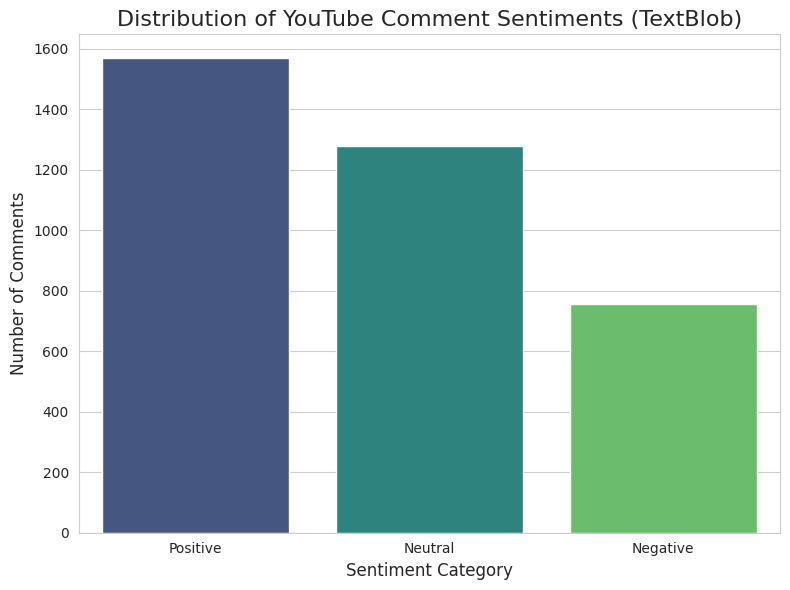

Traditional sentiment distribution visualized successfully.


In [34]:
# --- Visualize Traditional Sentiment Distribution ---

sentiment_counts = df['sentiment'].value_counts()

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, hue=sentiment_counts.index, palette='viridis', legend=False)
plt.title('Distribution of YouTube Comment Sentiments (TextBlob)', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.tight_layout()
plt.show()

print("Traditional sentiment distribution visualized successfully.")

In [35]:
# --- Traditional Keyword Extraction (Count-based) ---

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return []
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]  # Remove stopwords and single-character words
    return tokens

df['processed_text'] = df['text'].apply(preprocess_text)

all_words = [word for sublist in df['processed_text'].dropna() for word in sublist]
word_counts = Counter(all_words)

print("Traditional Keyword Extraction complete. Top 20 Most Frequent Words:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

Traditional Keyword Extraction complete. Top 20 Most Frequent Words:
black: 722
people: 562
like: 534
history: 503
white: 327
episode: 308
one: 272
story: 272
boondocks: 252
video: 212
dont: 207
even: 197
slave: 194
know: 192
slaves: 183
catcher: 179
slavery: 175
man: 175
get: 175
us: 168


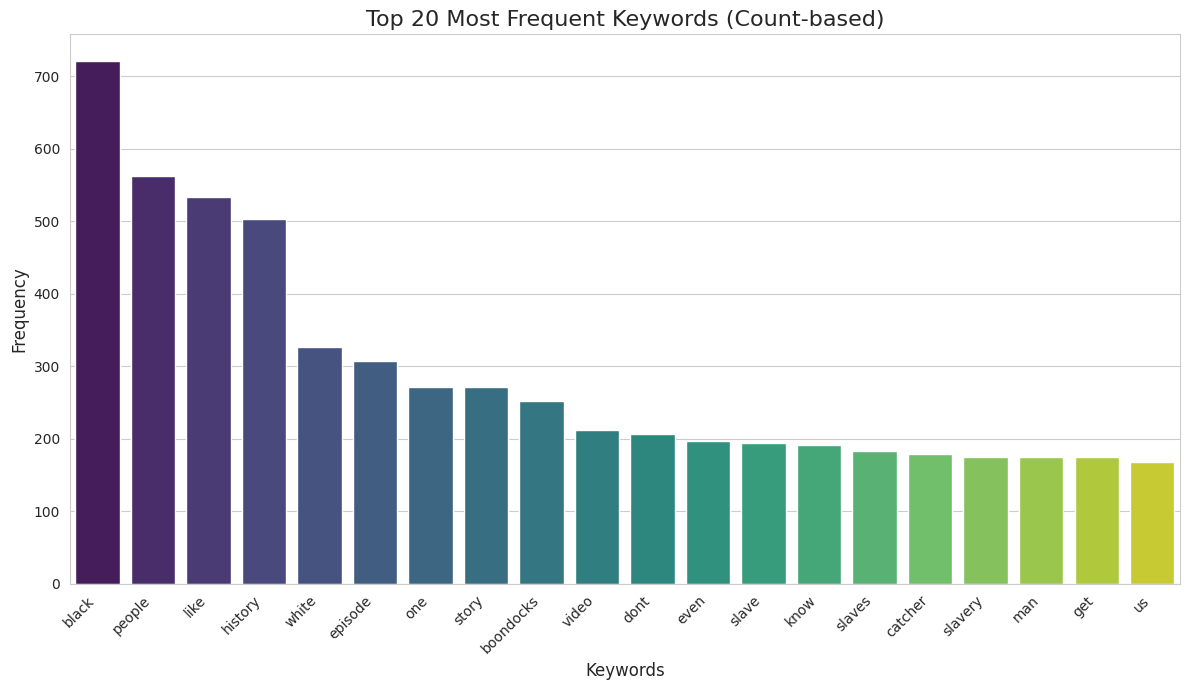

Traditional top keywords visualized successfully.


In [36]:
# --- Visualize Traditional Top Keywords ---

top_words = word_counts.most_common(20)
df_top_words = pd.DataFrame(top_words, columns=['Word', 'Count'])

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
sns.barplot(x='Word', y='Count', data=df_top_words, hue='Word', palette='viridis', legend=False)
plt.title('Top 20 Most Frequent Keywords (Count-based)', fontsize=16)
plt.xlabel('Keywords', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Traditional top keywords visualized successfully.")

In [37]:
# --- Deep Learning Sentiment Analysis (Transformers) ---

sentiment_pipeline = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_dl(text):
    if pd.isna(text) or not str(text).strip():
        return None, None
    try:
        text_str = str(text)
        if len(text_str) > 512:
            text_str = text_str[:512]
        result = sentiment_pipeline(text_str)[0]
        sentiment_label = result['label']
        sentiment_score = result['score']
        return sentiment_label, sentiment_score
    except Exception as e:
        return None, None

df[['dl_sentiment', 'dl_sentiment_score']] = df['text'].apply(lambda x: pd.Series(analyze_sentiment_dl(x)))

print("Deep Learning Sentiment Analysis (Transformers) complete. Displaying the first few rows with new 'dl_sentiment' and 'dl_sentiment_score' columns:")
display(df[['text', 'dl_sentiment', 'dl_sentiment_score']].head())

Device set to use cpu


Deep Learning Sentiment Analysis (Transformers) complete. Displaying the first few rows with new 'dl_sentiment' and 'dl_sentiment_score' columns:


,text,dl_sentiment,dl_sentiment_score
0,If you like this video consider watching my ch...,NEGATIVE,0.988601
1,Fred Hampton and Assada Shakur were Violent Cr...,NEGATIVE,0.948039
2,"Cinque, the hero of the film Amistad, became a...",NEGATIVE,0.998128
3,"Frankly, this revisionism is a human problem… ...",NEGATIVE,0.992036
4,"Damn, i got the wholeass episode and some good...",POSITIVE,0.934800


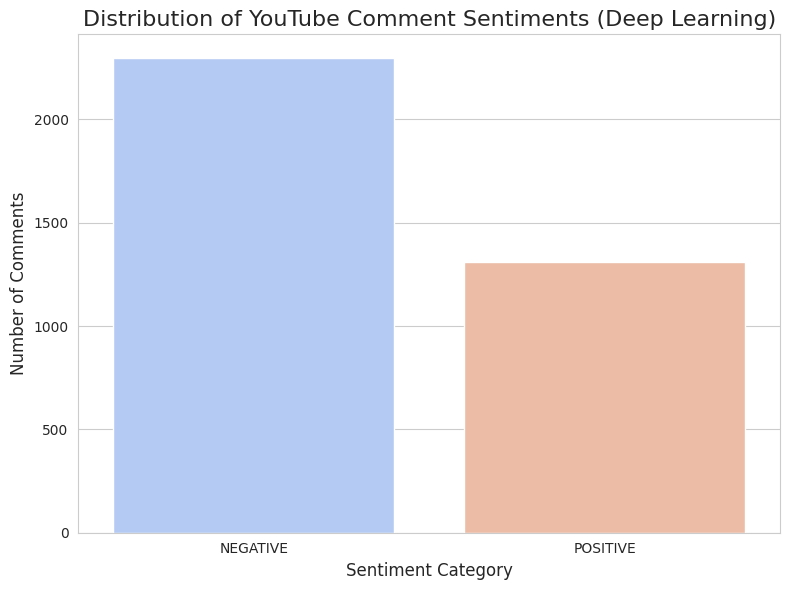

Deep Learning sentiment distribution visualized successfully.


In [38]:
# --- Visualize Deep Learning Sentiment Distribution ---

dl_sentiment_counts = df['dl_sentiment'].value_counts()

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=dl_sentiment_counts.index, y=dl_sentiment_counts.values, hue=dl_sentiment_counts.index, palette='coolwarm', legend=False)
plt.title('Distribution of YouTube Comment Sentiments (Deep Learning)', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.tight_layout()
plt.show()

print("Deep Learning sentiment distribution visualized successfully.")

In [39]:
# --- Deep Learning Keyword Extraction (KeyBERT) ---

kw_model = KeyBERT()

def extract_keywords_keybert(text):
    if pd.isna(text) or not str(text).strip():
        return []
    try:
        keywords = kw_model.extract_keywords(str(text), keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)
        return keywords
    except Exception as e:
        return []

df['keybert_keywords'] = df['text'].apply(extract_keywords_keybert)

print("Deep Learning Keyword Extraction (KeyBERT) complete. Displaying the first few rows with new 'keybert_keywords' column:")
display(df[['text', 'keybert_keywords']].head())

Deep Learning Keyword Extraction (KeyBERT) complete. Displaying the first few rows with new 'keybert_keywords' column:


,text,keybert_keywords
0,If you like this video consider watching my ch...,"[(character analysis, 0.6168), (watching chara..."
1,Fred Hampton and Assada Shakur were Violent Cr...,"[(shakur violent, 0.5823), (violent criminals,..."
2,"Cinque, the hero of the film Amistad, became a...","[(amistad slave, 0.638), (film amistad, 0.6114..."
3,"Frankly, this revisionism is a human problem… ...","[(cultural revisionism, 0.5769), (revisionism ..."
4,"Damn, i got the wholeass episode and some good...","[(wholeass episode, 0.6035), (episodes mlk, 0...."


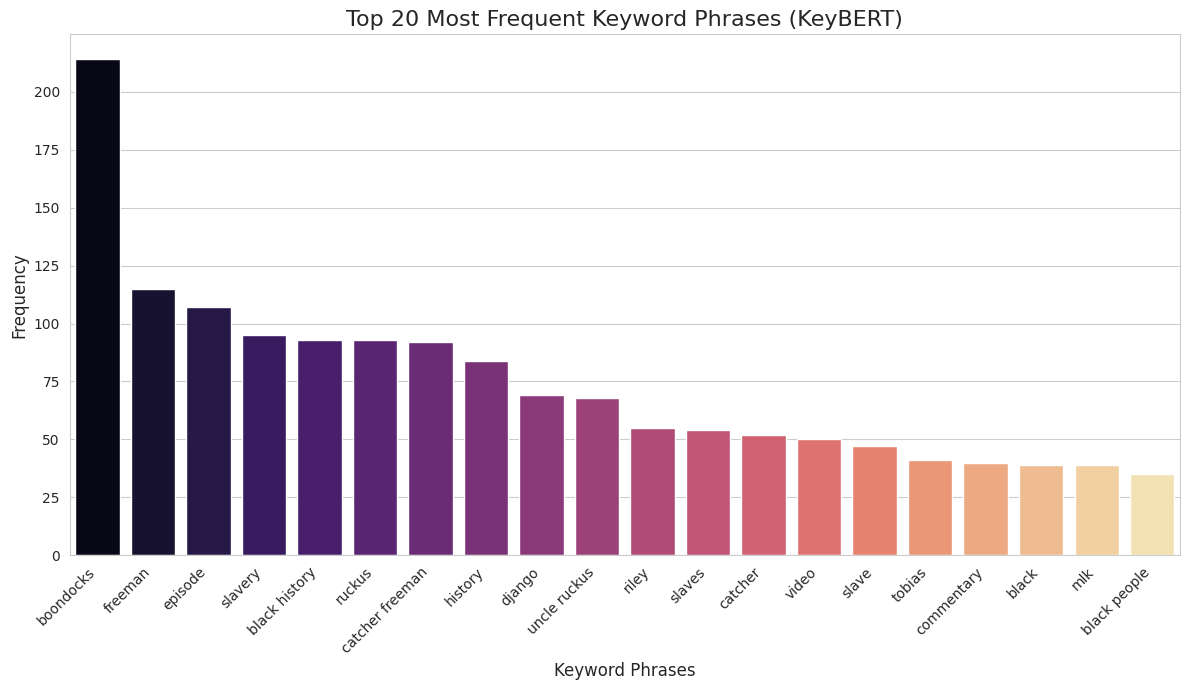

Deep Learning top keywords visualized successfully.


In [40]:
# --- Visualize Deep Learning Top Keywords ---

all_keybert_keywords = []
for keywords_list in df['keybert_keywords'].dropna():
    for keyword, score in keywords_list:
        all_keybert_keywords.append(keyword)

keybert_word_counts = Counter(all_keybert_keywords)
top_keybert_words = keybert_word_counts.most_common(20)
df_top_keybert_words = pd.DataFrame(top_keybert_words, columns=['Keyword Phrase', 'Count'])

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
sns.barplot(x='Keyword Phrase', y='Count', data=df_top_keybert_words, hue='Keyword Phrase', palette='magma', legend=False)
plt.title('Top 20 Most Frequent Keyword Phrases (KeyBERT)', fontsize=16)
plt.xlabel('Keyword Phrases', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Deep Learning top keywords visualized successfully.")

## Summary and Comparison of Analysis Methods

### Data Analysis Key Findings

*   **Dataset Loading:** The 'Sparkup Youtube_comments.csv.txt' dataset was successfully loaded, parsed, and prepared for analysis. It contains 3607 comments with relevant features like author, text, and likes.

### Sentiment Analysis Comparison:

*   **Traditional (TextBlob):** Categorized comments into 'Positive' (1570), 'Neutral' (1280), and 'Negative' (757). This approach tends to be more balanced, identifying a significant portion of neutral comments.
    *   **Insight:** Suggests a fair amount of content is perceived as neither strongly positive nor negative, or that TextBlob's lexical approach might struggle with nuance.

*   **Deep Learning (DistilBERT):** Identified 2297 'NEGATIVE' comments and 1310 'POSITIVE' comments. This model provides a binary classification and often captures more nuanced sentiment through contextual understanding.
    *   **Insight:** The deep learning model reveals a more pronounced negative sentiment in the dataset, which might be indicative of the controversial nature of the topics discussed, or the model's superior ability to detect implied negativity.

### Keyword Extraction Comparison:

*   **Traditional (Count-based):** Identified single words like 'black' (722), 'people' (562), 'like' (534), 'history' (503), and 'white' (327) as most frequent. These are general terms.
    *   **Insight:** Highlights broad themes but may miss the specific context or phrases that define topics.

*   **Deep Learning (KeyBERT):** Extracted more specific and contextually relevant keyword phrases such as 'boondocks' (214), 'freeman' (115), 'episode' (107), 'slavery' (95), and 'black history' (93).
    *   **Insight:** KeyBERT, leveraging BERT embeddings, provides richer and more actionable insights into the specific topics and entities discussed within the comments. This method captures keyphrases rather than just individual words, which is often more useful for content strategy.

### Overall Differences Highlighted:

*   **Sentiment Granularity:** Deep learning models can detect more subtle or implied sentiment, leading to different distributions (e.g., fewer 'Neutral' classifications) compared to rule-based or lexical approaches like TextBlob.
*   **Keyword Specificity:** Deep learning-based keyword extraction (KeyBERT) excels at identifying multi-word keyphrases that are more representative of the core topics, providing deeper insights than simple word frequency counts.

### Intelligent Recommendations:

1.  **Prioritize Deep Learning Insights:** Given its contextual understanding, rely more on the deep learning sentiment and keyword results for strategic decisions. The 'NEGATIVE' sentiment detected by DistilBERT warrants further investigation.

2.  **Investigate Negative Sentiment:** Analyze the content of the 2297 comments classified as 'NEGATIVE' by the deep learning model. Are they constructive criticism, complaints, or toxic comments? Understanding the *nature* of this negativity is crucial for community management and content moderation strategies.

3.  **Leverage KeyBERT Topics for Content Creation:** The specific keyword phrases identified by KeyBERT ('black history', 'boondocks', 'slavery', 'uncle ruckus', 'django') provide clear direction for content development. Creating more in-depth videos or series around these highly engaged topics can significantly boost audience interest and engagement.

4.  **Monitor Specific Discussions:** The presence of terms like 'Fred Hampton' and 'Assada Shakur' (even if less frequent overall) suggests specific historical or cultural figures are prominent. Monitor discussions around these figures to understand audience perspectives and identify potential content opportunities.

5.  **Refine Engagement Strategies:** If certain topics consistently draw negative sentiment, consider developing strategies to moderate discussions, provide additional context, or facilitate more constructive dialogue. For positive topics, explore ways to amplify that engagement.

This comprehensive analysis using both traditional and deep learning techniques provides a robust foundation for understanding audience feedback and informing future content strategy.